In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd 

import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import joblib
import pickle
import time

# Build a Transformer for Multivariate Time Series Modelling: 

## Step 1: 
* Build synthetic dataset and simplest possible model

## Step 2: 
* Convert synthetic data into PyTorch datasets/dataoaders
* Stack transformer blocks to expand learning capacity/model complexity.

## Step 3: 
* Curriculum learning
* Scheduled Sampling
* Phase-aware loss function
* Train-test-split
* Fix deployment inference window size

## Step 4: 
* Compare to a seqeunce-to-sequence LSTM model

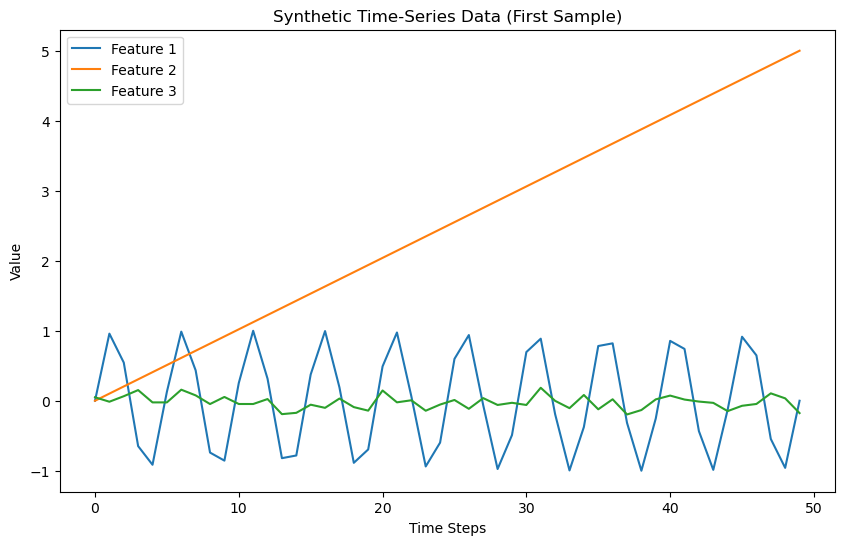

In [20]:
# Generate synthetic time-series data
def generate_synthetic_time_series(num_samples, time_steps, features):
    np.random.seed(42)
    t = np.linspace(0, 10, time_steps)  # Time axis
    
    # Generate synthetic features
    data = []
    for _ in range(num_samples):
        # Feature 1: Sine wave (seasonality)
        sine_wave = np.sin(2 * np.pi * t)
        
        # Feature 2: Linear trend
        trend = 0.5 * t
        
        # Feature 3: Random noise
        noise = 0.1 * np.random.randn(time_steps)
        
        # Combine features
        sample = np.stack([sine_wave, trend, noise], axis=-1)
        data.append(sample)
    
    data = np.array(data)  # Shape: [num_samples, time_steps, features]
    return data

# Parameters
num_samples = 1000
time_steps = 50
features = 3

# Generate data
data = generate_synthetic_time_series(num_samples, time_steps, features)

# Visualize the first sample
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(data[0, :, i], label=f'Feature {i+1}')
plt.title('Synthetic Time-Series Data (First Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
# Split data into input and target sequences
input_steps = 40  # Use past 40 time steps as input
output_steps = 10  # Predict next 10 time steps

# Create input and target sequences
inputs = data[:, :input_steps, :]  # Shape: [num_samples, input_steps, features]
targets = data[:, input_steps:input_steps+output_steps, :]  # Shape: [num_samples, output_steps, features]

# Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

In [28]:
def generate_causal_mask(size):
    """Generate a causal mask to prevent attending to future tokens."""
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

class Seq2SeqTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        
        self.model_dim = model_dim
        
        # Embedding layers
        self.encoder_embedding = nn.Linear(input_dim, model_dim)
        self.decoder_embedding = nn.Linear(input_dim, model_dim)
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, time_steps, model_dim))
        
        # Transformer
        self.transformer = nn.Transformer(d_model=model_dim, nhead=num_heads, num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        
        # Final linear layer
        self.fc_out = nn.Linear(model_dim, input_dim)
    
    def forward(self, src, tgt, tgt_mask=None):
        # Add positional encoding to the source and target sequences
        src = self.encoder_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt = self.decoder_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        
        # Transformer expects src and tgt to have shape [time_steps, batch_size, model_dim]
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        
        # Transformer forward pass
        transformer_output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        
        # Reshape output to [batch_size, time_steps, model_dim]
        transformer_output = transformer_output.permute(1, 0, 2)
        
        # Final linear layer
        output = self.fc_out(transformer_output)
        
        return output

In [34]:
# Initialize model, loss, and optimizer
model = Seq2SeqTransformer(input_dim=features, model_dim=64, num_heads=4, num_encoder_layers=2,
                           num_decoder_layers=2, dim_feedforward=256, dropout=0.1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    tgt_mask = generate_causal_mask(targets[:, :-1, :].size(1))  # Causal mask for decoder
    output = model(inputs, targets[:, :-1, :], tgt_mask=tgt_mask)  # Teacher forcing
    
    # Compute loss
    loss = criterion(output, targets[:, 1:, :])  # Compare predictions to shifted targets
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Loss: 9.9640
Epoch [2/20], Loss: 3.7396
Epoch [3/20], Loss: 1.7120
Epoch [4/20], Loss: 0.9507
Epoch [5/20], Loss: 0.6216
Epoch [6/20], Loss: 0.4650
Epoch [7/20], Loss: 0.3865
Epoch [8/20], Loss: 0.3382
Epoch [9/20], Loss: 0.3077
Epoch [10/20], Loss: 0.2863
Epoch [11/20], Loss: 0.2683
Epoch [12/20], Loss: 0.2549
Epoch [13/20], Loss: 0.2432
Epoch [14/20], Loss: 0.2293
Epoch [15/20], Loss: 0.2195
Epoch [16/20], Loss: 0.2113
Epoch [17/20], Loss: 0.2050
Epoch [18/20], Loss: 0.2007
Epoch [19/20], Loss: 0.1958
Epoch [20/20], Loss: 0.1933


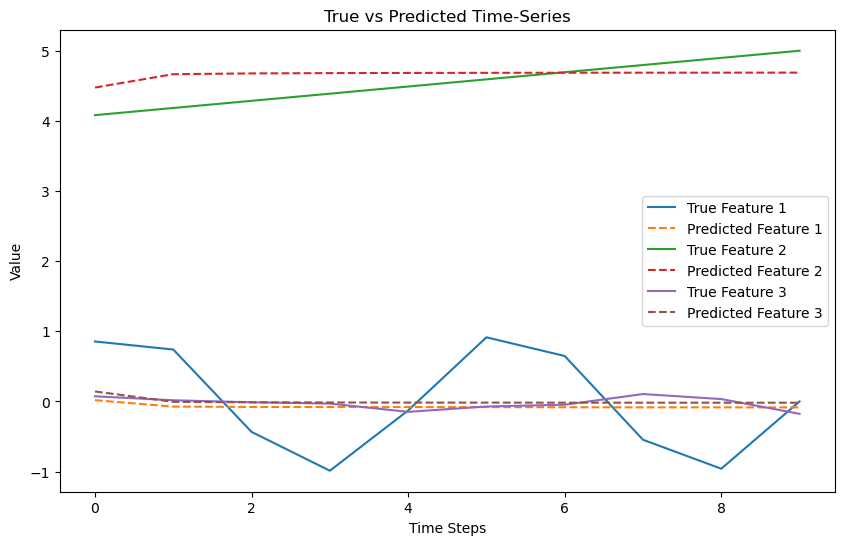

In [36]:
# Inference
model.eval()
with torch.no_grad():
    # Start with the input sequence as the initial decoder input
    initial_input = inputs[:, :1, :]  # Start with the first time step
    predictions = []
    for _ in range(output_steps):
        tgt_mask = generate_causal_mask(initial_input.size(1))  # Causal mask
        output = model(inputs, initial_input, tgt_mask=tgt_mask)
        next_step = output[:, -1:, :]  # Take the last predicted time step
        predictions.append(next_step)
        initial_input = torch.cat([initial_input, next_step], dim=1)  # Append to input
    
    predictions = torch.cat(predictions, dim=1)  # Shape: [batch_size, output_steps, features]

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(targets[0, :, i].numpy(), label=f'True Feature {i+1}')
    plt.plot(predictions[0, :, i].numpy(), label=f'Predicted Feature {i+1}', linestyle='--')
plt.title('True vs Predicted Time-Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# Stack and expand:

In [165]:
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Generate synthetic time-series data
def generate_synthetic_time_series(num_samples, time_steps, features):
    np.random.seed(42)
    t = np.linspace(0, 10, time_steps)  # Time axis
    
    # Generate synthetic features
    data = []
    for _ in range(num_samples):
        # Feature 1: Sine wave (seasonality)
        sine_wave = np.sin(2 * np.pi * t)
        
        # Feature 2: Linear trend
        trend = 0.5 * t
        
        # Feature 3: Random noise
        noise = 0.1 * np.random.randn(time_steps)
        
        # Combine features
        sample = np.stack([sine_wave, trend, noise], axis=-1)
        data.append(sample)
    
    data = np.array(data)  # Shape: [num_samples, time_steps, features]
    return data

In [ ]:
# Parameters
num_samples = 1000
time_steps = 50
features = 3

# Generate data
data = generate_synthetic_time_series(num_samples, time_steps, features)

# Split data into input and target sequences
input_steps = 40  # Use past 40 time steps as input
output_steps = 10  # Predict next 10 time steps

# Create input and target sequences
inputs = data[:, :input_steps, :]  # Shape: [num_samples, input_steps, features]
targets = data[:, input_steps:input_steps+output_steps, :]  # Shape: [num_samples, output_steps, features]

# # Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Create dataset and dataloader
dataset = TimeSeriesDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [167]:
# Generate causal mask
def generate_causal_mask(size):
    """Generate a causal mask to prevent attending to future tokens."""
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

class StackedSeq2SeqTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super(StackedSeq2SeqTransformer, self).__init__()
        
        self.model_dim = model_dim
        
        # Embedding layers
        self.encoder_embedding = nn.Linear(input_dim, model_dim)
        self.decoder_embedding = nn.Linear(input_dim, model_dim)
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, time_steps, model_dim))
        
        # Stacked Transformer Encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                      dim_feedforward=dim_feedforward, dropout=dropout,
                                      batch_first=True),  # Set batch_first=True
            num_layers=num_layers
        )
        
        # Stacked Transformer Decoder
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads,
                                      dim_feedforward=dim_feedforward, dropout=dropout,
                                      batch_first=True),  # Set batch_first=True
            num_layers=num_layers
        )
        
        # Final linear layer
        self.fc_out = nn.Linear(model_dim, input_dim)
    
    def forward(self, src, tgt, tgt_mask=None):
        # Add positional encoding to the source and target sequences
        src = self.encoder_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt = self.decoder_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        
        # Encoder forward pass
        memory = self.encoder(src)
        
        # Decoder forward pass
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        
        # Final linear layer
        output = self.fc_out(output)
        
        return output

In [169]:
# Model parameters
input_dim = features
model_dim = 64
num_heads = 4
num_layers = 2  # Stack 4 Transformer blocks
dim_feedforward = 64
dropout = 0.05

# Initialize the model
model = StackedSeq2SeqTransformer(input_dim, model_dim, num_heads, num_layers, dim_feedforward, dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [34]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for src, tgt in dataloader:
        # Forward pass
        tgt_mask = generate_causal_mask(tgt[:, :-1, :].size(1))  # Causal mask for decoder
        output = model(src, tgt[:, :-1, :], tgt_mask=tgt_mask)  # Teacher forcing
        
        # Compute loss
        loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0080
Epoch [2/5], Loss: 0.0056
Epoch [3/5], Loss: 0.0044
Epoch [4/5], Loss: 0.0044
Epoch [5/5], Loss: 0.0044


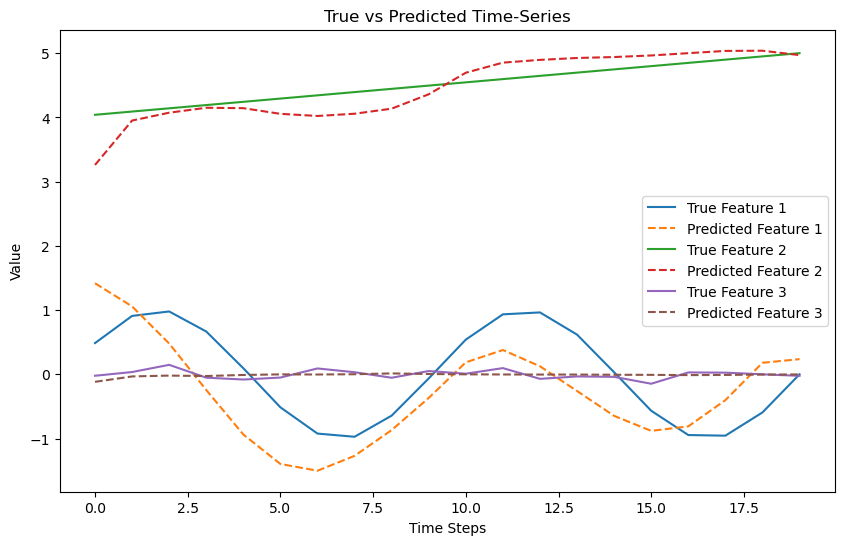

In [35]:
# Inference
model.eval()
with torch.no_grad():
    # Start with the input sequence as the initial decoder input
    initial_input = inputs[:, :1, :]  # Start with the first time step
    predictions = []
    for _ in range(output_steps):
        tgt_mask = generate_causal_mask(initial_input.size(1))  # Causal mask
        output = model(inputs, initial_input, tgt_mask=tgt_mask)
        next_step = output[:, -1:, :]  # Take the last predicted time step
        predictions.append(next_step)
        initial_input = torch.cat([initial_input, next_step], dim=1)  # Append to input
    
    predictions = torch.cat(predictions, dim=1)  # Shape: [batch_size, output_steps, features]

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(targets[0, :, i].numpy(), label=f'True Feature {i+1}')
    plt.plot(predictions[0, :, i].numpy(), label=f'Predicted Feature {i+1}', linestyle='--')
plt.title('True vs Predicted Time-Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# Fancy Transformer tricks! 

In [179]:
def scheduled_sampling(epoch, num_epochs, initial_prob=1.0, final_prob=0.1):
    """Linearly decrease the probability of teacher forcing."""
    return initial_prob - (initial_prob - final_prob) * (epoch / num_epochs)

def curriculum_learning(epoch, num_epochs, min_steps=10, max_steps=40):
    """Linearly increase the sequence length over epochs."""
    return min_steps + int((max_steps - min_steps) * (epoch / num_epochs))

def phase_difference_loss(y_true, y_pred):
    """Compute the phase difference loss between true and predicted signals."""
    # Compute cross-correlation
    cross_corr = torch.fft.ifft(torch.fft.fft(y_true) * torch.fft.fft(y_pred).conj()).real
    phase_diff = torch.argmax(cross_corr, dim=1)  # Find the phase shift that maximizes correlation
    phase_loss = torch.mean(torch.abs(phase_diff), dtype = float)  # Penalize large phase shifts
    return phase_loss

def combined_loss(y_true, y_pred, alpha=0.1):
    """Combine MSE loss with phase difference loss."""
    mse_loss = criterion(y_pred, y_true)  # Standard MSE loss
    phase_loss = phase_difference_loss(y_true, y_pred)  # Phase difference loss
    return mse_loss + alpha * phase_loss  # Weighted combination

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Scheduled Sampling:
# * Gradually mix teach forcing and autoregresssion in training phase. 

# Model parameters
input_dim = features
model_dim = 32
num_heads = 4
num_layers = 4  # Stack 4 Transformer blocks
dim_feedforward = 32
dropout = 0.1

# Initialize the model
model = StackedSeq2SeqTransformer(input_dim, model_dim, num_heads, num_layers, dim_feedforward, dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop with scheduled sampling and curriculum learning
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    teacher_forcing_prob = scheduled_sampling(epoch, num_epochs)
    sequence_length = curriculum_learning(epoch, num_epochs)
    
    # Create a new dataset with the current sequence length
    inputs_curr = inputs[:, :sequence_length, :]
    targets_curr = targets[:, :sequence_length, :]
    dataset_curr = TimeSeriesDataset(inputs_curr, targets_curr)
    dataloader_curr = DataLoader(dataset_curr, batch_size=32, shuffle=True)
    
    for src, tgt in dataloader_curr:
        # Forward pass
        tgt_mask = generate_causal_mask(tgt[:, :-1, :].size(1))  # Causal mask for decoder
        
        # Use teacher forcing with probability `teacher_forcing_prob`
        if np.random.rand() < teacher_forcing_prob:
            output = model(src, tgt[:, :-1, :], tgt_mask=tgt_mask)  # Teacher forcing
        else:
            # Autoregressive prediction
            output = []
            decoder_input = src[:, :1, :]  # Start with the first time step
            for _ in range(tgt.size(1) - 1):  # Predict for the same length as `tgt[:, 1:, :]`
                decoder_output = model(src, decoder_input, tgt_mask=generate_causal_mask(decoder_input.size(1)))
                next_step = decoder_output[:, -1:, :]  # Take the last predicted time step
                output.append(next_step)
                decoder_input = torch.cat([decoder_input, next_step], dim=1)  # Append to input
            output = torch.cat(output, dim=1)
        
        # Compute loss
        # loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
        loss = combined_loss(tgt[:, 1:, :], output, alpha=0.1)  # Use combined loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Seq Len: {sequence_length}, TF Prob: {teacher_forcing_prob:.4f}, Loss: {loss.item():.4f}')

Epoch [1/25], Seq Len: 10, TF Prob: 1.0000, Loss: 0.9628
Epoch [2/25], Seq Len: 11, TF Prob: 0.9640, Loss: 0.7242
Epoch [3/25], Seq Len: 12, TF Prob: 0.9280, Loss: 0.7045
Epoch [4/25], Seq Len: 13, TF Prob: 0.8920, Loss: 0.6727
Epoch [5/25], Seq Len: 14, TF Prob: 0.8560, Loss: 0.6069
Epoch [6/25], Seq Len: 16, TF Prob: 0.8200, Loss: 0.6524
Epoch [7/25], Seq Len: 17, TF Prob: 0.7840, Loss: 0.6001
Epoch [8/25], Seq Len: 18, TF Prob: 0.7480, Loss: 0.5790
Epoch [9/25], Seq Len: 19, TF Prob: 0.7120, Loss: 0.5355
Epoch [10/25], Seq Len: 20, TF Prob: 0.6760, Loss: 0.4982
Epoch [11/25], Seq Len: 22, TF Prob: 0.6400, Loss: 0.5441
Epoch [12/25], Seq Len: 23, TF Prob: 0.6040, Loss: 0.5089
Epoch [13/25], Seq Len: 24, TF Prob: 0.5680, Loss: 0.4995
Epoch [14/25], Seq Len: 25, TF Prob: 0.5320, Loss: 0.5237
Epoch [15/25], Seq Len: 26, TF Prob: 0.4960, Loss: 0.5261
Epoch [16/25], Seq Len: 28, TF Prob: 0.4600, Loss: 0.5259
Epoch [17/25], Seq Len: 29, TF Prob: 0.4240, Loss: 0.5041
Epoch [18/25], Seq Len:

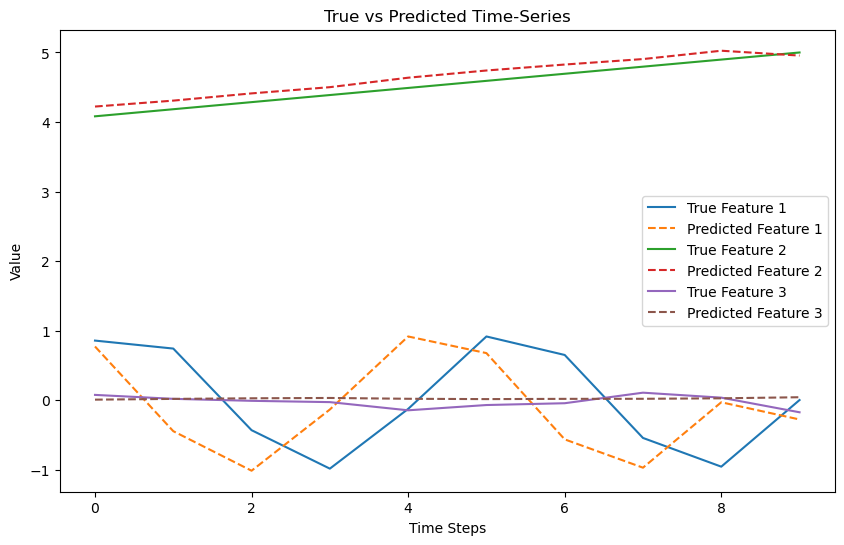

In [181]:
# Inference
model.eval()
with torch.no_grad():
    # Start with the input sequence as the initial decoder input
    initial_input = inputs[:, :1, :]  # Start with the first time step
    predictions = []
    for _ in range(output_steps):
        tgt_mask = generate_causal_mask(initial_input.size(1))  # Causal mask
        output = model(inputs, initial_input, tgt_mask=tgt_mask)
        next_step = output[:, -1:, :]  # Take the last predicted time step
        predictions.append(next_step)
        initial_input = torch.cat([initial_input, next_step], dim=1)  # Append to input
    
    predictions = torch.cat(predictions, dim=1)  # Shape: [batch_size, output_steps, features]

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(targets[0, :, i].numpy(), label=f'True Feature {i+1}')
    plt.plot(predictions[0, :, i].numpy(), label=f'Predicted Feature {i+1}', linestyle='--')
plt.title('True vs Predicted Time-Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [183]:
print( f"The stacked Seq2Seq Transformer has {count_parameters(model)} learnable parameters.")

The stacked Seq2Seq Transformer has 70819 learnable parameters.


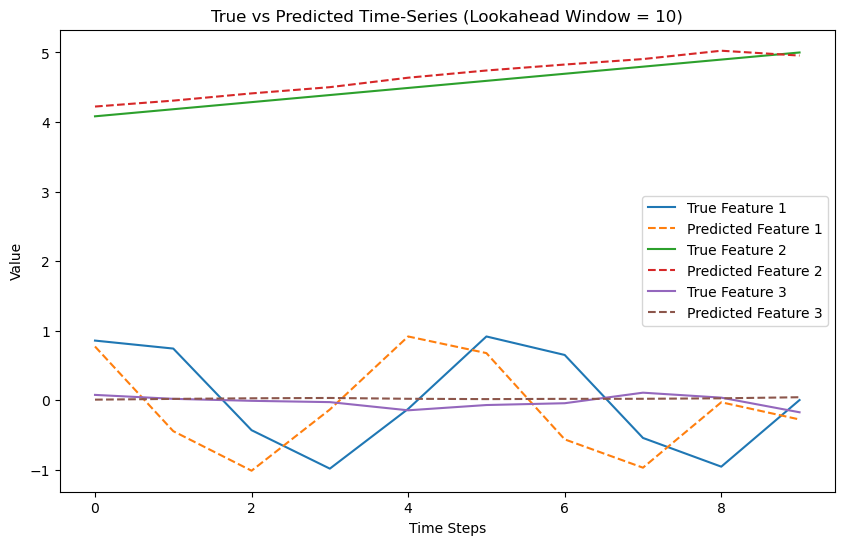

In [185]:
# Inference with a locked lookahead window
lookahead_window = 10  # Set the desired lookahead window
model.eval()
with torch.no_grad():
    # Start with the input sequence as the initial decoder input
    initial_input = inputs[:, :1, :]  # Start with the first time step
    predictions = []
    for _ in range(lookahead_window):  # Predict exactly `lookahead_window` steps
        tgt_mask = generate_causal_mask(initial_input.size(1))  # Causal mask
        output = model(inputs, initial_input, tgt_mask=tgt_mask)
        next_step = output[:, -1:, :]  # Take the last predicted time step
        predictions.append(next_step)
        initial_input = torch.cat([initial_input, next_step], dim=1)  # Append to input
    
    predictions = torch.cat(predictions, dim=1)  # Shape: [batch_size, lookahead_window, features]

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(targets[0, :lookahead_window, i].numpy(), label=f'True Feature {i+1}')
    plt.plot(predictions[0, :, i].numpy(), label=f'Predicted Feature {i+1}', linestyle='--')
plt.title(f'True vs Predicted Time-Series (Lookahead Window = {lookahead_window})')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# Add train-test split and validation steps

In [70]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

# Create DataLoader for training and validation sets
train_dataset = TimeSeriesDataset(train_inputs, train_targets)
val_dataset = TimeSeriesDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [78]:
import time

# Training loop with timing and validation loss tracking
num_epochs = 10
validation_interval = 5  # Compute validation loss every 5 epochs

# Initialize lists to store losses and times
train_losses = []
val_losses = []
epoch_times = []

# Start total training time
total_start_time = time.time()

for epoch in range(num_epochs):
    # Start epoch time
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    train_loss = 0.0
    for src, tgt in train_dataloader:
        # Forward pass
        tgt_mask = generate_causal_mask(tgt[:, :-1, :].size(1))  # Causal mask for decoder
        
        # Use teacher forcing with probability `teacher_forcing_prob`
        if np.random.rand() < scheduled_sampling(epoch, num_epochs):
            output = model(src, tgt[:, :-1, :], tgt_mask=tgt_mask)  # Teacher forcing
        else:
            # Autoregressive prediction
            output = []
            decoder_input = src[:, :1, :]  # Start with the first time step
            for _ in range(tgt.size(1) - 1):  # Predict for the same length as `tgt[:, 1:, :]`
                decoder_output = model(src, decoder_input, tgt_mask=generate_causal_mask(decoder_input.size(1)))
                next_step = decoder_output[:, -1:, :]  # Take the last predicted time step
                output.append(next_step)
                decoder_input = torch.cat([decoder_input, next_step], dim=1)  # Append to input
            output = torch.cat(output, dim=1)
        
        # Compute loss
        loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
        train_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Average training loss for the epoch
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    # Validation phase (every `validation_interval` epochs)
    if (epoch + 1) % validation_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for src, tgt in val_dataloader:
                # Forward pass
                tgt_mask = generate_causal_mask(tgt[:, :-1, :].size(1))  # Causal mask for decoder
                output = model(src, tgt[:, :-1, :], tgt_mask=tgt_mask)  # Teacher forcing
                
                # Compute loss
                loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
                val_loss += loss.item()
        
        # Average validation loss
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

            # End epoch time
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Seq Len: {sequence_length}, '
              f'TF Prob: {teacher_forcing_prob:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')
    else:
        val_losses.append(None)  # No validation this epoch
    
        # End epoch time
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Seq Len: {sequence_length}, '
              f'TF Prob: {teacher_forcing_prob:.4f}, '
              f'No Val this epoch, ' # for some reason the val_loss throws a string formatting error
              f'Epoch Time: {epoch_time:.2f}s')

# End total training time
total_time = time.time() - total_start_time
print(f'Total Training Time: {total_time:.2f}s')

Epoch [1/10], Train Loss: 0.0035, Seq Len: 37,TF Prob: 0.1900,No Val this epoch, Epoch Time: 4.17s
Epoch [2/10], Train Loss: 0.0035, Seq Len: 37,TF Prob: 0.1900,No Val this epoch, Epoch Time: 11.09s
Epoch [3/10], Train Loss: 0.0035, Seq Len: 37,TF Prob: 0.1900,No Val this epoch, Epoch Time: 17.98s


KeyboardInterrupt: 

# LSTM for comparison (awful)

In [189]:
class LSTMSeg2Seg(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.1):
        super(LSTMSeg2Seg, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Decoder LSTM
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Linear layer to project hidden state to output dimension
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        # Linear layer to project hidden state to input dimension (for autoregressive prediction)
        self.hidden_to_input = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, src, tgt):
        # Encoder forward pass
        _, (hidden, cell) = self.encoder(src)  # hidden/cell shape: [num_layers, batch_size, hidden_dim]
        
        # Decoder forward pass
        outputs = []
        decoder_input = tgt[:, :1, :]  # Start with the first time step (shape: [batch_size, 1, input_dim])
        for _ in range(tgt.size(1)):  # Predict for the same length as the target sequence
            # Decoder step
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            
            # Project hidden state to output dimension
            output = self.fc_out(output)  # Shape: [batch_size, 1, output_dim]
            outputs.append(output)
            
            # Update decoder input for the next step
            decoder_input = self.hidden_to_input(hidden[-1].unsqueeze(1))  # Shape: [batch_size, 1, input_dim]
        
        # Stack outputs
        outputs = torch.cat(outputs, dim=1)  # Shape: [batch_size, seq_len, output_dim]
        
        return outputs

In [191]:
# Model parameters
features = 3
input_dim = features  # Number of features (3 in our case)
hidden_dim = 32
output_dim = features  # Same as input_dim for seq2seq
num_layers = 4
dropout = 0.1

# Initialize the LSTM model
lstm_model = LSTMSeg2Seg(input_dim, hidden_dim, output_dim, num_layers, dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [193]:
# Training loop for LSTM
num_epochs = 5
validation_interval = 5  # Compute validation loss every 5 epochs

# Initialize lists to store losses and times
train_losses = []
val_losses = []
epoch_times = []

# Start total training time
total_start_time = time.time()

for epoch in range(num_epochs):
    # Start epoch time
    epoch_start_time = time.time()
    
    # Training phase
    lstm_model.train()
    train_loss = 0.0
    for src, tgt in train_dataloader:
        # Forward pass
        output = lstm_model(src, tgt[:, :-1, :])  # Teacher forcing
        
        # Compute loss
        loss = combined_loss(tgt[:, 1:, :], output, alpha=0.1)  # Use combined loss
        # loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
        train_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Average training loss for the epoch
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    # # Validation phase (every `validation_interval` epochs)
    # if (epoch + 1) % validation_interval == 0:
    #     lstm_model.eval()
    #     val_loss = 0.0
    #     with torch.no_grad():
    #         for src, tgt in val_dataloader:
    #             # Forward pass
    #             output = lstm_model(src, tgt[:, :-1, :])  # Teacher forcing
                
    #             # Compute loss
    #             loss = criterion(output, tgt[:, 1:, :])  # Compare predictions to shifted targets
    #             val_loss += loss.item()
        
    #     # Average validation loss
    #     val_loss /= len(val_dataloader)
    #     val_losses.append(val_loss)
    # else:
    #     val_losses.append(None)  # No validation this epoch
    
    # End epoch time
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          # f'Val Loss: {val_losses[-1]:.4f if val_losses[-1] is not None else "N/A"}, '
          f'Epoch Time: {epoch_time:.2f}s')

# End total training time
total_time = time.time() - total_start_time
print(f'Total Training Time: {total_time:.2f}s')

Epoch [1/5], Train Loss: 1.8067, Epoch Time: 14.12s
Epoch [2/5], Train Loss: 1.0710, Epoch Time: 14.17s
Epoch [3/5], Train Loss: 1.0101, Epoch Time: 14.02s
Epoch [4/5], Train Loss: 1.1450, Epoch Time: 14.04s
Epoch [5/5], Train Loss: 1.1758, Epoch Time: 14.05s
Total Training Time: 70.40s


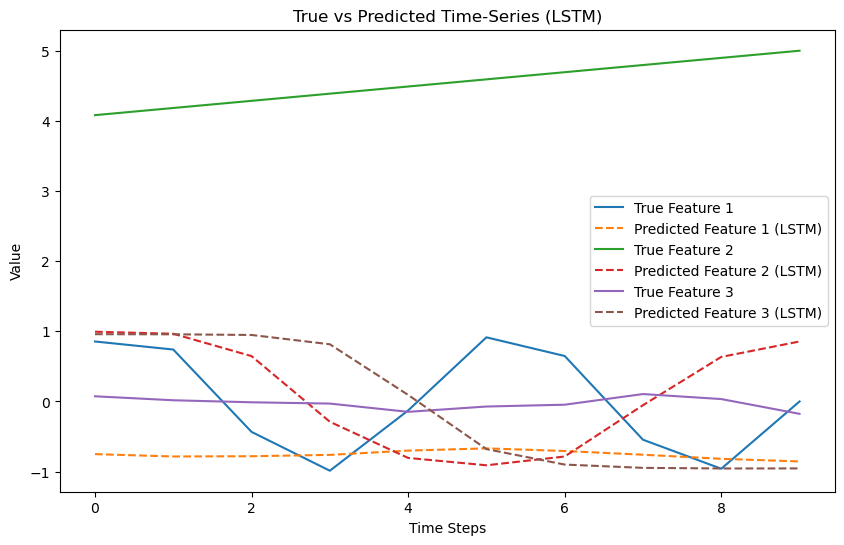

In [195]:
# Inference with LSTM
lstm_model.eval()
with torch.no_grad():
    # Start with the input sequence as the initial decoder input
    initial_input = inputs[:, :1, :]  # Start with the first time step
    predictions = []
    hidden, cell = None, None
    
    # Encoder forward pass to get the initial hidden state
    _, (hidden, cell) = lstm_model.encoder(inputs)
    
    for _ in range(output_steps):
        # Decoder step
        output, (hidden, cell) = lstm_model.decoder(initial_input, (hidden, cell))
        next_step = output[:, -1:, :]  # Take the last predicted time step
        predictions.append(next_step)
        
        # Update decoder input for the next step
        initial_input = lstm_model.hidden_to_input(hidden[-1].unsqueeze(1))  # Shape: [batch_size, 1, input_dim]
    
    predictions = torch.cat(predictions, dim=1)  # Shape: [batch_size, output_steps, features]

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(features):
    plt.plot(targets[0, :, i].numpy(), label=f'True Feature {i+1}')
    plt.plot(predictions[0, :, i].numpy(), label=f'Predicted Feature {i+1} (LSTM)', linestyle='--')
plt.title('True vs Predicted Time-Series (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()